In [94]:
import numpy as np
from scipy.interpolate import interp1d
import concurrent.futures
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Class for every single gamma ray

In [95]:
class gamma_water():
    def __init__(self):
        #Initialize position, energy and direction (limit initial position near the origin)
        random_points = np.random.randn(3)
        length = np.linalg.norm(random_points)
        max_length = 0.5
        if length > max_length:
            random_points = random_points / length * max_length
        self.track = [random_points]
        self.energy = [np.random.uniform(0.1, 1)]
        direction_vector = np.random.rand(3)
        unit_vector = direction_vector / np.linalg.norm(direction_vector)
        self.direction = [unit_vector]
        # The boundary of simulation is a cubic from (-1,-1,-1) to (1,1,1)
        self.out = False
        self.energy_decay = False
        self.end = False
        self.energy_loss = 0

    # from one scatter to another
    def run_single(self):
        last_location = self.track[-1] + self.direction[-1]*self.sample_scattering_distances()
        if np.all((last_location >= -1) & (last_location <= 1)):
            new_energy, theta = self.compton_scattering(self.energy[-1])
            if new_energy>0.1:
                self.energy.append(new_energy)
                # Update direction after scattering
                new_direction = self.update_direction(self.direction[-1], theta)
                self.direction.append(new_direction)
                self.track.append(last_location)
            else:
                self.energy_decay = True
                self.energy_loss = self.energy[0] - 0.1
                self.end = True

        else:
            self.out = True
            self.end = True
            self.energy_loss = self.energy[0] - self.energy[-1]

    # whole process
    def run(self):
        max_step = 10000

        # Termination Condition
        while not self.end:
            self.run_single()
            if len(self.energy)>max_step:
                self.end = True


    def compton_scattering(self, energy):
        # Sampling theta based on Klein-Nishina probability distribution
        theta = self.sample_klein_nishina_theta(energy)
        scattered_energy = energy / (1 + (energy / 0.511) * (1 - np.cos(theta)))
        return scattered_energy, theta
        
    def sample_klein_nishina_theta(self, energy):
        # Constants
        rest_mass_electron = 0.511  # MeV
        alpha = energy / rest_mass_electron
        theta = np.linspace(0, np.pi, 1000)
        # Klein-Nishina formula as PDF
        pdf = (3/(16*np.pi)) * (1/(1 + alpha*(1 - np.cos(theta))))**2 * \
              (1 + np.cos(theta)**2 + ((alpha**2) * (1 - np.cos(theta))**2) / (1 + alpha*(1 - np.cos(theta))))
        pdf /= np.trapz(pdf, theta)  # Normalize the PDF
        
        # Cumulative distribution function from PDF
        cdf = np.cumsum(pdf) * np.diff(np.hstack((0, theta)))
        # Inverse transform sampling
        random_cdf = np.random.uniform()
        theta_sampled = np.interp(random_cdf, cdf, theta)
        return theta_sampled

    def update_direction(self, old_direction, theta):
        # Generate a random axis perpendicular to the old direction
        # Random vector that is not parallel to old_direction
        v = np.random.randn(3)
        axis = np.cross(old_direction, v)  # Cross product to find a perpendicular vector
        axis /= np.linalg.norm(axis)  # Normalize the axis
        
        # Rodrigues' rotation formula
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        new_direction = (cos_theta * old_direction +
                         sin_theta * np.cross(axis, old_direction) +
                         (1 - cos_theta) * np.dot(axis, old_direction) * axis)
        return new_direction

    def sample_scattering_distances(self):
        """
        Samples scattering distances for gamma rays using an exponential distribution.
        """
        energy = self.energy[-1]
        # Generating distances
        distances = np.random.exponential(scale=mfp_interpolation(energy))
        return distances



### Run the simulation 1000 times with multi processing

In [96]:
# Energy values in MeV and cross-sections in cm^2/g
energies = np.array([0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0, 1.022, 1.25, 1.5, 2.0, 2.044, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0])
cross_sections = np.array([1.654E-01, 1.481E-01, 1.356E-01, 1.180E-01, 1.058E-01, 9.665E-02, 8.940E-02, 7.857E-02, 7.066E-02, 6.991E-02, 6.320E-02, 5.752E-02, 4.940E-02, 4.881E-02, 3.968E-02, 3.402E-02, 3.031E-02, 2.770E-02, 2.577E-02, 2.429E-02, 2.313E-02, 2.219E-02])


# Calculate mean free paths in m
mean_free_paths = 1 / cross_sections / 100  # Since the density of water is 1 g/cm^3

# Create an interpolation function
mfp_interpolation = interp1d(energies, mean_free_paths, kind='linear', fill_value="extrapolate")

def run_simulation():
    instance = gamma_water()
    instance.run()
    return instance

num_samples = 1000
results = []

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(run_simulation) for _ in range(num_samples)]
    for future in concurrent.futures.as_completed(futures):
        results.append(future.result())

### Statistics about energy loss and absorption rate

In [97]:
num_out = 0
total_energyloss = 0
for t in results:
    if t.out==True:
        num_out += 1
    #print(len(t.energy))
    total_energyloss += t.energy_loss

ratio_out = num_out/num_samples

avg_energyloss = total_energyloss/num_samples

print("Ratio of going out:", ratio_out)
print("Average energy loss:", avg_energyloss)

Ratio of going out: 0.026
Average energy loss: 0.4372898435989483


### Plot ten tracks of gamma ray

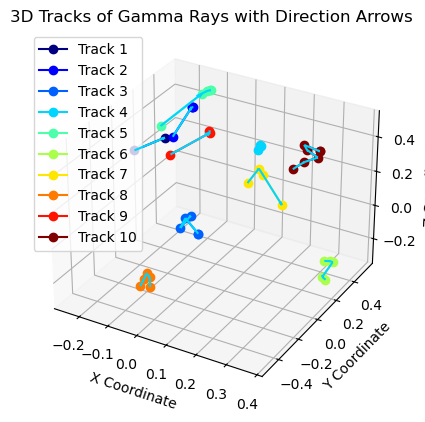

In [99]:
tracks = []
for t in results[:10]:
    tracks.append(t.track)

# Colors for each track
colors = plt.cm.jet(np.linspace(0, 1, len(tracks)))

# Create a new figure for the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Loop through each track using enumerate for proper indexing
for idx, track in enumerate(tracks):
    # Extracting x, y, z coordinates from track data
    x = [point[0] for point in track]
    y = [point[1] for point in track]
    z = [point[2] for point in track]

    # Plotting the track as a 3D line
    ax.plot(x, y, z, label=f'Track {idx + 1}', marker='o', color=colors[idx])


    # Adding arrows to show the direction of the path
    for i in range(len(x) - 1):
        ax.quiver(x[i], y[i], z[i], x[i+1] - x[i], y[i+1] - y[i], z[i+1] - z[i], color=color, arrow_length_ratio=0.1)

# Adding labels and title
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
ax.set_title('3D Tracks of Gamma Rays with Direction Arrows')

# Display legend
ax.legend()

# Show the plot
plt.show()
